Mounted at /content/drive
Summary Statistics:
            DOWNLOAD        UPLOAD
count  35427.000000  35427.000000
mean   19052.251090    482.140941
std    10213.032412    267.930799
min     2335.885000     57.749000
25%    11342.646000    264.406500
50%    18816.920000    475.543000
75%    26627.177000    668.998000
max    43930.614000   1670.995000

Correlation Matrix:
           DOWNLOAD    UPLOAD
DOWNLOAD  1.000000  0.993714
UPLOAD    0.993714  1.000000

Download Anomalies:
 Empty DataFrame
Columns: [SERVER_NAME, DOWNLOAD, UPLOAD, DOWNLOAD_ZSCORE, UPLOAD_ZSCORE]
Index: []

Upload Anomalies:
 Empty DataFrame
Columns: [SERVER_NAME, DOWNLOAD, UPLOAD, DOWNLOAD_ZSCORE, UPLOAD_ZSCORE]
Index: []


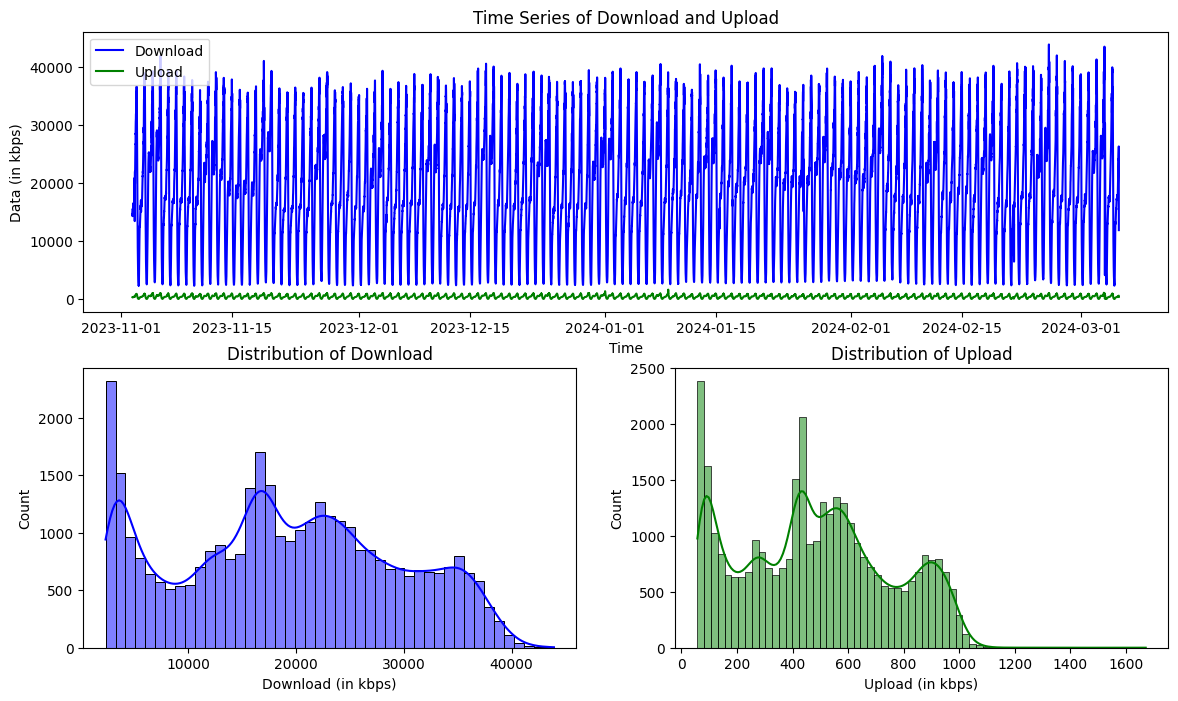

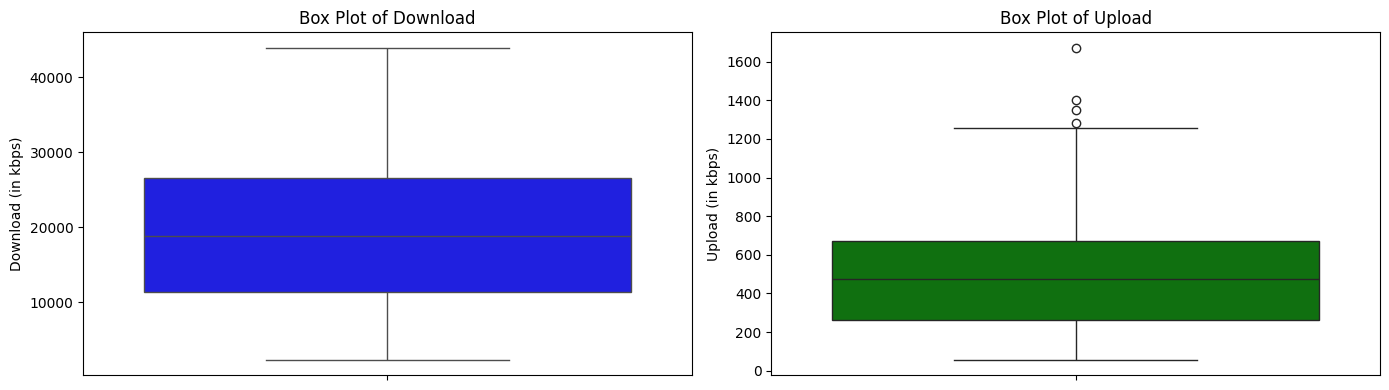

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_excel('/content/drive/My Drive/dataset.xlsx')

# Load the dataset
file_path = 'dataset.xlsx'

# Convert TIME_STAMP to datetime format
if 'TIME_STAMP' not in df.columns:
    raise KeyError("Column 'TIME_STAMP' not found in the dataset.")
df['TIME_STAMP'] = pd.to_datetime(df['TIME_STAMP'])

# Set TIME_STAMP as index
df.set_index('TIME_STAMP', inplace=True)

# Summary statistics
summary_stats = df.describe()
print("Summary Statistics:\n", summary_stats)

# Correlation matrix (exclude non-numeric columns)
numeric_df = df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()
print("\nCorrelation Matrix:\n", correlation_matrix)

# Z-Score calculation for anomaly detection
df['DOWNLOAD_ZSCORE'] = zscore(df['DOWNLOAD'])
df['UPLOAD_ZSCORE'] = zscore(df['UPLOAD'])

# Identify anomalies (absolute z-score > 3)
download_anomalies = df[df['DOWNLOAD_ZSCORE'].abs() > 3]
upload_anomalies = df[df['UPLOAD_ZSCORE'].abs() > 3]

print("\nDownload Anomalies:\n", download_anomalies)
print("\nUpload Anomalies:\n", upload_anomalies)

# Plotting
plt.figure(figsize=(14, 8))

# Time series plot
plt.subplot(2, 1, 1)
plt.plot(df.index, df['DOWNLOAD'], label='Download', color='blue')
plt.plot(df.index, df['UPLOAD'], label='Upload', color='green')
plt.title('Time Series of Download and Upload')
plt.xlabel('Time')
plt.ylabel('Data (in kbps)')
plt.legend()

# Distribution plots
plt.subplot(2, 2, 3)
sns.histplot(df['DOWNLOAD'], kde=True, color='blue')
plt.title('Distribution of Download')
plt.xlabel('Download (in kbps)')

plt.subplot(2, 2, 4)
sns.histplot(df['UPLOAD'], kde=True, color='green')
plt.title('Distribution of Upload')
plt.xlabel('Upload (in kbps)')

# Box plots
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['DOWNLOAD'], color='blue')
plt.title('Box Plot of Download')
plt.ylabel('Download (in kbps)')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['UPLOAD'], color='green')
plt.title('Box Plot of Upload')
plt.ylabel('Upload (in kbps)')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Anomaly detected!
Target DOWNLOAD Z-Score: -11.52262969055626
Target UPLOAD Z-Score: -6.74763565475264
The anomaly is more significant in the DOWNLOAD value.


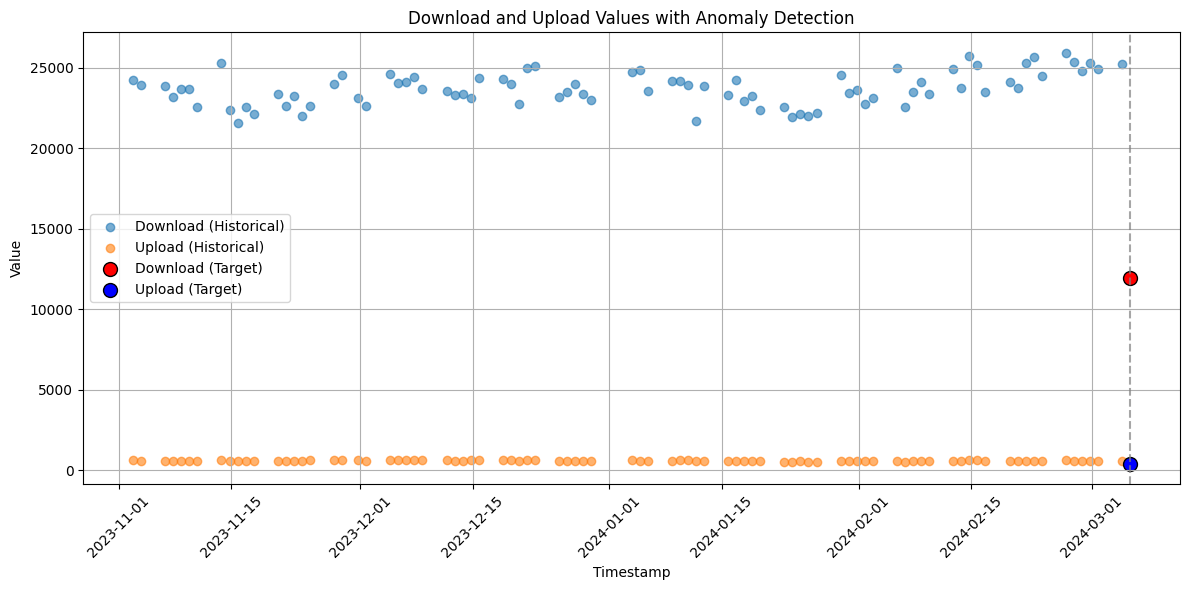

Anomaly Prediction: [-1]


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

#Turkish Holidays
turkish_holidays_2024 = [
    '2024-01-01', '2024-04-23', '2024-05-01', '2024-05-19', '2024-07-15',
    '2024-08-30', '2024-10-29', # National holidays
    '2024-03-28', '2024-03-29', '2024-03-30', # Ramadan Feast
    '2024-06-15', '2024-06-16', '2024-06-17', # Sacrifice Feast
]

turkish_holidays_2024 = pd.to_datetime(turkish_holidays_2024)

target_time = pd.Timestamp('2024-03-05 18:25:00')
target_data = df[df.index == target_time]

# Filter historical data
historical_data = df[df.index.weekday < 5]
historical_data = historical_data[historical_data.index.time == target_time.time()]
historical_data = historical_data[~historical_data.index.normalize().isin(turkish_holidays_2024)]

#missing value process
historical_data[['DOWNLOAD', 'UPLOAD']] = historical_data[['DOWNLOAD', 'UPLOAD']].interpolate()

# Remove to outliers
Q1 = historical_data[['DOWNLOAD', 'UPLOAD']].quantile(0.25)
Q3 = historical_data[['DOWNLOAD', 'UPLOAD']].quantile(0.75)
IQR = Q3 - Q1
historical_data = historical_data[~((historical_data[['DOWNLOAD', 'UPLOAD']] < (Q1 - 1.5 * IQR)) | (historical_data[['DOWNLOAD', 'UPLOAD']] > (Q3 + 1.5 * IQR))).any(axis=1)]

# download and upload data used for train data
X_train = historical_data[['DOWNLOAD', 'UPLOAD']]

#Isolation Forest model used for anomaly detection
model = IsolationForest(contamination=0.01, random_state=42)
model.fit(X_train)

# anomaly prediction
X_target = target_data[['DOWNLOAD', 'UPLOAD']]
anomaly_prediction = model.predict(X_target)

# Check if the target data is an anomaly
if anomaly_prediction[0] == -1:
    print('Anomaly detected!')

    #Z-score calculate
    historical_data['DOWNLOAD_ZSCORE'] = (historical_data['DOWNLOAD'] - historical_data['DOWNLOAD'].mean()) / historical_data['DOWNLOAD'].std()
    historical_data['UPLOAD_ZSCORE'] = (historical_data['UPLOAD'] - historical_data['UPLOAD'].mean()) / historical_data['UPLOAD'].std()

    target_download_zscore = (target_data['DOWNLOAD'] - historical_data['DOWNLOAD'].mean()) / historical_data['DOWNLOAD'].std()
    target_upload_zscore = (target_data['UPLOAD'] - historical_data['UPLOAD'].mean()) / historical_data['UPLOAD'].std()

    print('Target DOWNLOAD Z-Score:', target_download_zscore.values[0])
    print('Target UPLOAD Z-Score:', target_upload_zscore.values[0])

    if abs(target_download_zscore.values[0]) > abs(target_upload_zscore.values[0]):
        print('The anomaly is more significant in the DOWNLOAD value.')
    else:
        print('The anomaly is more significant in the UPLOAD value.')
else:
    print('No anomaly detected.')


plt.figure(figsize=(12, 6))
plt.scatter(historical_data.index, historical_data['DOWNLOAD'], label='Download (Historical)', alpha=0.6)
plt.scatter(historical_data.index, historical_data['UPLOAD'], label='Upload (Historical)', alpha=0.6)

plt.scatter(target_data.index, target_data['DOWNLOAD'], label='Download (Target)', color='red', s=100, edgecolor='k')
plt.scatter(target_data.index, target_data['UPLOAD'], label='Upload (Target)', color='blue', s=100, edgecolor='k')

plt.axvline(x=target_time, color='gray', linestyle='--', alpha=0.7)

plt.title('Download and Upload Values with Anomaly Detection')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print('Anomaly Prediction:', anomaly_prediction)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


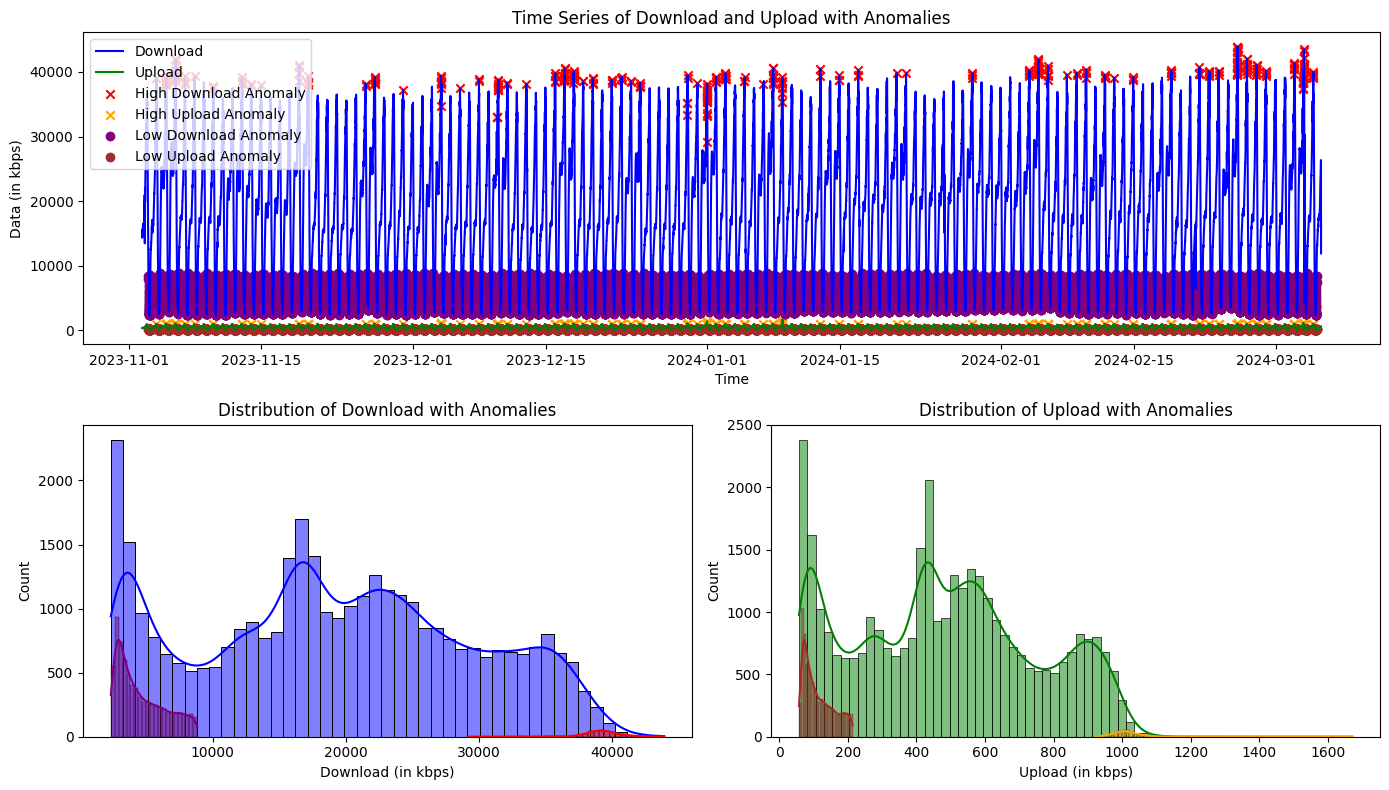

In [8]:
# Interpolate missing values
df['DOWNLOAD'] = df['DOWNLOAD'].interpolate()
df['UPLOAD'] = df['UPLOAD'].interpolate()

#Calculate Z-score
df['DOWNLOAD_ZSCORE'] = zscore(df['DOWNLOAD'])
df['UPLOAD_ZSCORE'] = zscore(df['UPLOAD'])

#Isolation Forest model
model = IsolationForest(contamination=0.01, random_state=42)
model.fit(df[['DOWNLOAD', 'UPLOAD']])

#anomaly prediction
df['IF_ANOMALY'] = model.predict(df[['DOWNLOAD', 'UPLOAD']])
df['IF_ANOMALY'] = df['IF_ANOMALY'].map({1: 0, -1: 1})  # Convert -1 to 1 for anomalies

# Identify low anomalies
low_threshold = -1  # This can be adjusted based on your specific requirements
df['LOW_DOWNLOAD_ANOMALY'] = df['DOWNLOAD_ZSCORE'] < low_threshold
df['LOW_UPLOAD_ANOMALY'] = df['UPLOAD_ZSCORE'] < low_threshold

# Combine both Isolation Forest and low anomaly detections
df['ANOMALY'] = df['IF_ANOMALY'] | df['LOW_DOWNLOAD_ANOMALY'] | df['LOW_UPLOAD_ANOMALY']

# Separate anomalies
high_anomalies = df[(df['IF_ANOMALY'] == 1)]
low_download_anomalies = df[df['LOW_DOWNLOAD_ANOMALY']]
low_upload_anomalies = df[df['LOW_UPLOAD_ANOMALY']]


plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(df.index, df['DOWNLOAD'], label='Download', color='blue')
plt.plot(df.index, df['UPLOAD'], label='Upload', color='green')
plt.scatter(high_anomalies.index, high_anomalies['DOWNLOAD'], color='red', label='High Download Anomaly', marker='x')
plt.scatter(high_anomalies.index, high_anomalies['UPLOAD'], color='orange', label='High Upload Anomaly', marker='x')
plt.scatter(low_download_anomalies.index, low_download_anomalies['DOWNLOAD'], color='purple', label='Low Download Anomaly', marker='o')
plt.scatter(low_upload_anomalies.index, low_upload_anomalies['UPLOAD'], color='brown', label='Low Upload Anomaly', marker='o')
plt.title('Time Series of Download and Upload with Anomalies')
plt.xlabel('Time')
plt.ylabel('Data (in kbps)')
plt.legend()

plt.subplot(2, 2, 3)
sns.histplot(df['DOWNLOAD'], kde=True, color='blue')
sns.histplot(high_anomalies['DOWNLOAD'], kde=True, color='red')
sns.histplot(low_download_anomalies['DOWNLOAD'], kde=True, color='purple')
plt.title('Distribution of Download with Anomalies')
plt.xlabel('Download (in kbps)')

plt.subplot(2, 2, 4)
sns.histplot(df['UPLOAD'], kde=True, color='green')
sns.histplot(high_anomalies['UPLOAD'], kde=True, color='orange')
sns.histplot(low_upload_anomalies['UPLOAD'], kde=True, color='brown')
plt.title('Distribution of Upload with Anomalies')
plt.xlabel('Upload (in kbps)')

plt.tight_layout()
plt.show()
